# Relatório de Sequenciamento Genético

Este relatório tem como foco o problema de alinhamento de sequências de DNA, que consiste no processo de comparar duas ou mais sequências de bases, de forma a se observar seu nível de similaridade. Esse nível de similaridáde é definído pela pontuação feita na comparação entre as duas sequências.

O Cálculo dessa pontuação é encontrado usando as seguinte regras:
    - Cada comparação será feita um único caracter de cada sequência.
    - Se a comparação for um MATCH soma +2 ao valor total.
    - Se a comparação for um MISMATCH soma -1 ao valor total.
    - Se a comparação for um GAP soma -1 ao valor total.

Abaixo segue exemplo de como as regras de contuação interagem:

<span style="color:red">MISMATCH</span> 
<span style="color:blue">GAP</span> 
<span style="color:green">MATCH</span> </br>

![Cálculo do alinhamento](./alignment.png "alignment.png")

Usamos 3 tipos de abordagem para lidar com esse problema.

- [Heurística (Smith-Walterman)](/heuristica/heuristica.ipynb)

- [Busca Local](/busca_local/busca_local.ipynb)

- [Busca Exaustiva](/busca_exaustiva/busca_exaustiva.ipynb)

Os gráficos a seguir foram construídos utilizando 100 arquivos de input. Cada um possui a seguinte estruturação:
- Tamanho da sequência 1
- Tamanho da sequência 2
- Sequência 1 gerada de forma aleatória
- Sequência 2 gerada de forma aleatória

Pode visualizar um exemplo nesse [link](/testes/input01.seq)

## Fazendo imports

In [86]:
import os
import time
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.figure_factory as ff

import numpy as np
from scipy.spatial import Delaunay

u = np.linspace(0, 2*np.pi, 20)
v = np.linspace(0, 2*np.pi, 20)
u,v = np.meshgrid(u,v)
u = u.flatten()
v = v.flatten()

# x = (3 + (np.cos(v)))*np.cos(u)
# y = (3 + (np.cos(v)))*np.sin(u)
# z = np.sin(v)

points2D = np.vstack([u,v]).T
tri = Delaunay(points2D)
simplices = tri.simplices

## Criando listas que cotém o tamanho das sequências

In [116]:
testes = os.listdir('testes')
testesE = os.listdir('testes_exaustivo')

list_n = []
for teste in testes:
    with open('testes/{}'.format(teste)) as f :
        text_splitted = f.read().splitlines()
    f.close()
    list_n.append(text_splitted[0])
list_n = [int(x) for x in list_n]

list_m = []
for teste in testes:
    with open('testes/{}'.format(teste)) as f :
        text_splitted = f.read().splitlines()
    f.close()
    list_m.append(text_splitted[1])
list_m = [int(x) for x in list_m]

list_n_small = []
for teste in testesE:
    with open('testes_exaustivo/{}'.format(teste)) as f :
        text_splitted = f.read().splitlines()
    f.close()
    list_n_small.append(text_splitted[0])
list_n_small = [int(x) for x in list_n_small]

list_m_small = []
for teste in testesE:
    with open('testes_exaustivo/{}'.format(teste)) as f :
        text_splitted = f.read().splitlines()
    f.close()
    list_m_small.append(text_splitted[1])
list_m_small = [int(x) for x in list_m_small]

# with open('n-sizesE') as f:
#     list_nE = f.read().split("\n")
#     del list_nE[-1]
# testesE = os.listdir('testes_exaustivo')
# testesE.sort()
# with open('m-sizesE') as f:
#     list_mE = f.read().split("\n")
#     del list_mE[-1]

## Função para calcular o teste "t" para a o algorítimo "e" especificado:

In [114]:
def roda_com_entrada(t, e):
  with open(f'testes/{t}') as f:
    start = time.perf_counter()
    proc = subprocess.run([e], input=f.read(), text=True, capture_output=True)
    end = time.perf_counter()
  return [end-start, proc.stdout]

In [117]:
list_smith = []
list_smith_result = []
list_local = []
list_local_result = []
list_local_omp = []
list_local_omp_result = []
list_exaustiva = []
list_exaustiva_result = []
list_exaustiva_GPU = []
list_exaustiva_GPU_result = []

In [118]:
for t in testes:
  tmp = roda_com_entrada(t,'./smith')
  list_smith.append(tmp[0])
  list_smith_result.append(tmp[1])
  tmp = roda_com_entrada(t,'./local')
  list_local.append(tmp[0])
  list_local_result.append(tmp[1])
  tmp = roda_com_entrada(t,'./local_omp')
  list_local_omp.append(tmp[0])
  list_local_omp_result.append(tmp[1])
  tmp = roda_com_entrada(t,'./gpu_exaustiva')
  list_exaustiva_GPU.append(tmp[0])
  list_exaustiva_GPU_result.append(tmp[1])

In [119]:
for t in testesE:
  tmp = roda_com_entrada(t,'./smith')
  list_smith.append(tmp[0])
  list_smith_result.append(tmp[1])
  tmp = roda_com_entrada(t,'./local')
  list_local.append(tmp[0])
  list_local_result.append(tmp[1])
  tmp = roda_com_entrada(t,'./local_omp')
  list_local_omp.append(tmp[0])
  list_local_omp_result.append(tmp[1])
  tmp = roda_com_entrada(t,'./gpu_exaustiva')
  list_exaustiva_GPU.append(tmp[0])
  list_exaustiva_GPU_result.append(tmp[1])

## Gráfico para a Heurística

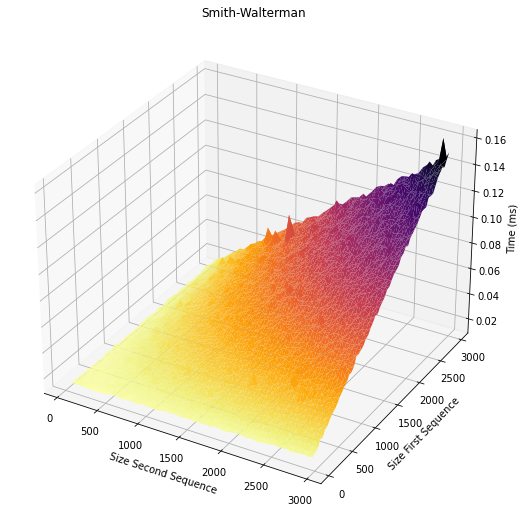

In [120]:
graph = plt.figure(figsize=(30,55))
smithG = graph.add_subplot(133, projection='3d')
smithG.plot_trisurf(list_m, list_n, list_smith,cmap='inferno_r')
smithG.set_xlabel('Size Second Sequence')
smithG.set_ylabel('Size First Sequence')
smithG.set_zlabel('Time (ms)')
smithG.set_title('Smith-Walterman');

O gráfico acima nós mostra que quanto maior for o tamanho da sequência mais tempo irá demorar para que o programa execute. Isso se dá pelo fato do Smith ser um algoritmo que cria uma matriz que vai relacionar todos os caracteres de uma sequência a todos os caracteres da outra sequência. Esse tipo de algoritmo é classificado como algoritmos de exploitation, pois eles olham de forma sequencial os máximos locais. O que demanda tempo pois funciona como uma varredura nas possibilidades.

## Proffiling

O principal responsável pelo decaimento do desempenho do código com relação ao tempo é a criação da matriz. Pois se tivermos sequências muito grandes a matriz será maior ainda. 
Como forma de verificação dessa afirmação, gerei um valgrind do executável.

![Valgrind](vall_smith.png "vall_smith.png")


## Gráfico para a Busca Local

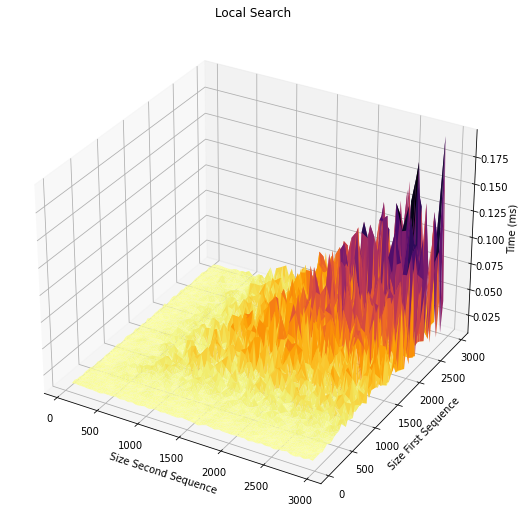

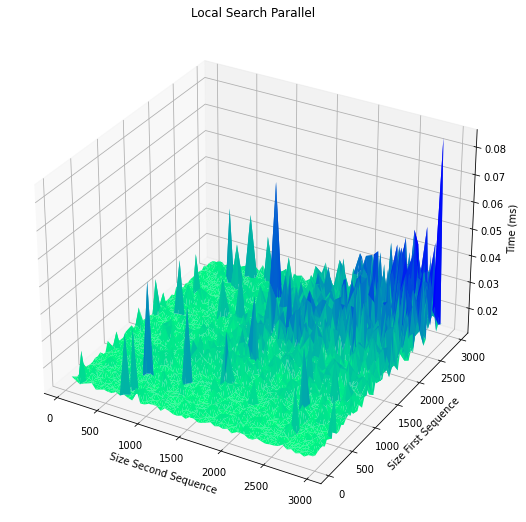

In [121]:
graph = plt.figure(figsize=(30,55))
smithG = graph.add_subplot(133, projection='3d')
smithG.plot_trisurf(list_m, list_n, list_local,cmap='inferno_r')
smithG.set_xlabel('Size Second Sequence')
smithG.set_ylabel('Size First Sequence')
smithG.set_zlabel('Time (ms)')
smithG.set_title('Local Search');

graph = plt.figure(figsize=(30,55))
smithG = graph.add_subplot(133, projection='3d')
smithG.plot_trisurf(list_m, list_n, list_local_omp,cmap='winter_r')
smithG.set_xlabel('Size Second Sequence')
smithG.set_ylabel('Size First Sequence')
smithG.set_zlabel('Time (ms)')
smithG.set_title('Local Search Parallel');

# fig = ff.create_trisurf(x=list_m, y=list_n, z=list_local_omp,
#                          simplices=simplices,
#                          title="Local Search", aspectratio=dict(x=1, y=1, z=0.3))
# fig.show()

O algoritmo de busca local performa com uma velocidade menor que a do Smith. Mas isso se deve ao fato dele ser um algoritmo focado em exploration e não em exploitation. Algoritmos de exploração olham para posições  aleatórias da sequência, no intuito de eventualmente achar casos melhores que os seus locais. Isso gera muitos resultados ruins, porém diminui consideravelmente o tempo de processamento para sequências gigantes.

Ao incluir o parallel for no código, foi interessante notar que o gráfico parece ter menos ruídos pois eles vinham da parte que estamos otimizando agora que é o cálculo do score das substrings. Porém, como é necessário fazer o uso da zona crítica no código, pois o cálculo de maior score é compartilhado entre as threads que são criadas pelo parallel for, existem momentos em que essa zona crítica se torna um gargalo para o processo e com o intuito de lhe dar com isso da melhor forma possível o código acaba tendo problemas na hora de otimizar o uso das threads, esse processo faz com que alguns casos demorem mais que o de CPU.

Há também a possibilidade de que o gerenciamento de uma zona crítica para o código que é tão simples quanto o busca local é acabe não valendo a pena para casos muito mequenos, se tivesse mais tempo eu tentaria rodar para casos maior e imagino que esse comportamento começaria a beneficiar o código paralelisado.

## Proffiling

O principal responsável pelo decaimento do desempenho do código com relação ao tempo é a chamada recursiva que ele faz para usar o algoritmo. O que faz sentido pois ele não necessita da criação de uma matriz como o algoritmo acima.

![Valgrind](vall_local.png "vall_local.png")

## Gráfico para a Busca Exaustiva

Tive alguns problemas rodando o algoritimo da busca exaustiva utilizando python.
Por algum motivo o mesmo executável se recusa a rodar através da execução utilizando o run do subprocess em python. Mas quando executado pelo terminal ele performa muito bem, como é possível ver no comparativo abaixo.
("exa_print"=="exa"+COUT => Logo, exa era pra performar melhor que exa_print)

![exa_print](terminal_exaustiva.png)

Compreendo que o print abaixo esteja redundante, mas já tirei a redundancia do codigo de criação da lista de exaustiva e mesmo assim demora 20 minutos e não conclui nem o [input04.seq](/testes_exaustivo/input04.seq), o que usando pelo terminal conclui em menos de 2 minutos outros até mais longos.

![exa_python](exa_python.png)

Tendo em vista que os outros algoritimos executam cadeias bem mais longas que [essas](/testes_exaustivo/) que estou passando para a exaustiva, e em poucos segundos, a conclusão que tiro é que pelo fato da Exaustiva repetir o cálculo do Smith ou da busca-local para cada combinação sequenciada possível de suas sequências ela funciona quase como um cálculo com fatorial, parece consufo o que estou falando, mas vou exemplificar:
- Para sequencias de mesmo tamanho
- Se fizermos o Smith para uma sequencia de tamanho N e depois para uma de tamanho N+1, a diferença de células processadas será de (2N + 1) o que já é um aumento considerável.
- Já no caso da Exaustiva para uma sequencia de tamanho N e depois para uma de tamanho N+1, a diferença de células processadas será de (2N + 1)(N+1)³, tendo em vista que a construção da exaustiva foi feita somente com o uso do Smith-Walterman e não com o da Busca Local. Para um N muito grande o dominante na equação se torna o (N+1)³, que tem seu comportamento expresso no gráfico a baixo:

![n3](n3.png) ![tabn3](tabela_n3.png)

A equação encontrada na tabela foi modelada por mim com base nas constraints que especifiquei acima e no comportamento natural da exaustiva modelada em código. (Meu código está um pouco diferente pois leva em consideração que para sequencias de tamanhos similares será feito o cálculo similar ao da busca local que é o mais simples. Porém como dito anteriormente a parte dominante do algorítimo é o modelo que calculei a cima que é estritamente ligado ao crescimento da busca exaustiva, logo provando assim que não faz diferença se você usa Smith ou uma comparação direta para fazer os calculos de máximo.)

    Caso seja necessário tenho a construção da modelagem em foto. Tá um pouco bagunçada mas posso explicar o raciocínio sem problema. Tenho dislexia e por isso me sinto muito desconfortável escrevendo textos muito longos. Mas se for necessário, posso aprontar uma apresentação de powerpoint para explicar meu raciocínio lógico.

Nas entregas anteriores não fui capaz de rodar os testes na exaustiva pelo fato das entradas serem muito grandes e tomar muito tempo. Tendo em vista que a busca exaustiva gera todas as possiveis combinações de substrings entre a comparação de duas strings completas, como apresentei anteriormente. Tendo isso em mente, fui instruido a produzir agora códigos que rodassem de forma paralela na GPU do computador, com o objetivo de distribuir o processamento e ganhar ganhar tempo. O famoso dividir pra conquistar.

A GPU se difere da CPU por ter mais unidades de logica aritimetica (ALU) e por essas unidades terem a capacidade de trabalharem de forma independente e não sequencial o que torna o processamento de uma grande quantidade de dados muito mais eficiente se esse processamento for divisível. 

A biblioteca utilizada para lidar com a GPU foi o Thrust. Ela foi utulizada pois simplifica a parte de código ao disponibilizar funções predefinidas como o transform, o inclusive scan e o reduce, fazendo com que não seja necessário trabalhar com níveis mais baixos de abstração.

Infelizmente não consegui rodar a tempo os testes exaustivos por falta de tempo. Isso se deu ao fato de algumas escolhas ruins que tomei.

Meu código anterior da exaustiva tinha problemas de otimização devido ao fato de ser gerado todas as possíveis combinações de subsequencias entre as duas sequencias dadas e os cáculos serem feitos em cima da combinatória de cada uma dessas sequências o tempo para rodar em CPU ficava até impossivel de determinar tendo em vista que uso sequências grandes e que a CPU normalmente não paralelisa processos como a GPU faz.

Para a GPU tentei tomar um caminho diferente do que os meus colegas tomaram  pois fazendo alguns testes em sala de aula notei que mesmo usando a GPU o tempo de resposta do código ainda era muito lento. Encontrei a NVBIO, biblioteca desenvolvida pela NVIDIA para lidar com longas cadeias de alinhamentos genéticos, o que é o gargalo no nosso projeto. Nosso grande problema é que as cadeias são muito grandes e não podemos ficar passando informações o tempo todo entre a GPU e a CPU pois isso consome muito tempo. O que a NVBIO se disponibiliza a fazer é usar de alguns artificios como o encapsulamento de strings em packages, depois do dado dentro da GPU essa lib fornece meios mais eficientes de se trabalhar a manipulação de indices e queries criando um ambiente onde conseguimos dentro da GPU dividir a cadeia em collections ainda menores para que os processos rodem de forma mais independente que com o Thrust. A grande dificuldade que tive com essa lib é que ela foi descontinua e não recebe atualização desde 2020, o que na minha opnião é estranho pois tivemos o COVID e hoje, mais do que nunca, conseguimos compreender a necessidade desse tipo de projeto para o meio científico. 

Acabei perdendo muito do tempo que tinha tentando resolver os problemas de versionamento que a NVBIO tinha, mas não obtive sucesso.

Pelo fato do Thrust utilizar o NVCC, que é o compilador do CUDA, para o projeto é necessário que o computador tenha suporte para tal. Minha placa mãe 1050ti é da NVIDIA, mas o CUDA não da suporte para ela, logo minhas duas opções eram o monstrão ou o colab. Deixei um código rodando no monstrão mas por algum motivo ele parou de rodar durante o final de semana e não sei o que rolou ainda. Tentei fazer pelo COLAB, mas apesar de deixar o PC ligado o tempo todo esse fim de semana o COLAB tem um sistema de TIMEOUT que impossibilitou que o código rodasse até o fim.

O gráfico abaixo serve como exemplo do que acontece com a execução de um código criado em nvcc, dentro de um computador no qual o não há uma placa suportada pelo CUDA. A execução acontece porém nenhum erro é apontado durante o processo além dos couts que não são executados.

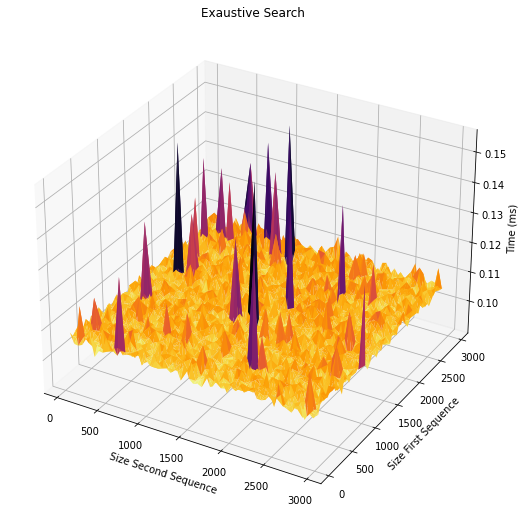

In [127]:
graph = plt.figure(figsize=(30,55))
smithG = graph.add_subplot(133, projection='3d')
smithG.plot_trisurf(list_m, list_n, list_exaustiva_GPU,cmap='inferno_r')
smithG.set_xlabel('Size Second Sequence')
smithG.set_ylabel('Size First Sequence')
smithG.set_zlabel('Time (ms)')
smithG.set_title('Exaustive Search');


# fig = ff.create_trisurf(x=list_m, y=list_n, z=list_exaustiva_GPU,
#                          simplices=simplices,
#                          title="Torus", aspectratio=dict(x=1, y=1, z=0.3))
# fig.show()

O devido comportamento executado pela GPU deveria ter um tempo de execução maior que o da CPU inicialmente, para sequencias menores, popis é como distribuir para muitos uma quantidade pouca de tarefas, você gasta mais tempo fazendo a distribuição, executando em seguida em paralelo e unindo os resultados depois do que se você sozinho executasse tudo em sequencia. 
Porém, para sequencias de tamanhos maiores devida a quantidade de ações necessárias tem um ponto que começa a valer a pena gastar um tempo com a distribuição e união das tarefas.
Gostaria de poder mostrar gráfico bonitos que demonstrassem essa variação, mas os problemas que enfrentei durante o projeto tornaram isso inviável.
É possivel rodar o código de forma unitária, mas para a construção dos gráficos desse relatório utilizei entradas muito grandes que acabam tornando o processo inviável para ser rodado em um curto período de tempo.

# Conclusão

Tendo em vista que o comportamento da busca-local segue um padrão mais randomico e distribuido em termos de tempo de processamento e que seus resultados podem vir a ser muito ruins, não compensando muito a economia com tempo, os dois que tem mais credibilidade são a Exaustiva e o algoritimo de Smith.

Apesar disso, é possivel notar através da comparação dos dois gráficos, do paralelismo da busca local, que com o aumento do tamanho das strings o processo vai ficar cada vez mais demorada impossibilitando eventualmente o uso de processo sequencial o que faz com que o processo paralelo seja extremamente necessário ao fazer esse tipo de análise.

Olhando para os dados e modelos apresentados conseguimos concluir que a busca exaustiva em GPU se criada de forma eficaz e otimizada, se torna a melhor opção que temos para a análise e execução do processo de alinhamento genético, tendo em vista que o mesmo utiliza de cadeias extremamente grandes o que no caso seria impossível de rodar em uma CPU.

Algumas otimizações de código a serem levadas em consideração seria a troca do tipo de char utilizado para construção das strings. Na biblioteca da NVBIO é utilizado um tipo de char String_Package que parece ser mais eficiente para usos na GPU. Isos pode não parecer grande coisa, mas a unidade em que o char são armazenados tem um potencial muito grande de encarecer o processo de alinhamento feito no código.

